# Modal analysis of a 3D-propeller

In this notebook we have a cantilever beam which is clamped at the left-hand side and a force is applied on the right hand side.

This is an example of a dynamic structure which will be a benchmark on which we will apply modal analysis later on.

We will impport dolfin, mshr and the python packages numpy and pyplot.

In [1]:
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

The example is a domain with length of 1 meter and a width of 2.5 centimeters. We take material properties of steel and do not take damping into account by setting it to zero.

The force applied is a lineaic pressure of 100 kPa per meter at the end of the beam. This gives 2,5 kN force per meter if we take the height of 2,5 cm into account.

Gravity is taken into account but it can be neglected under the current material properties and applied load. However, for future applications of modal analysis it is easy to have a body force included as well.

In [2]:
# Elasticity parameters
E, nu = 2.1e9, 0.3
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))

# Mass density and viscous damping coefficient
rho, eta = 7.8e4, 0.0

# applied force
force = -1e5
grav = -9.81

Creating a mesh and its boundaries:

In [3]:
# Set parameters
r = 0.125
R = 0.5
w = 0.3
h = 0.025
rotate_blades = True
include_tip = False
extra_rotation = True # only applied to inner mesh
resolution = 25

# Define geometries
sphere = Sphere(Point(0, 0, 0), 2*R)
geometry_inside = CSGGeometries.propeller(r, R, w, h, rotate_blades, include_tip)
geometry_outside = sphere - geometry_inside

# Generate meshes
mesh = generate_mesh(geometry_inside, resolution)
mesh_outside = generate_mesh(geometry_outside, resolution)

# Report size of meshes
print("Mesh of propeller inside:  %d cells" % mesh.num_cells())
print("Mesh of propeller outside: %d cells" % mesh_outside.num_cells())

# Save meshes to file
File("propeller_fixed/propeller_inside.pvd") << mesh
File("propeller_fixed/propeller_outside.pvd") << mesh_outside

Mesh of propeller inside:  20071 cells
Mesh of propeller outside: 59639 cells


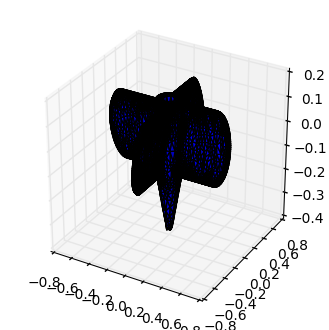

In [8]:
plot(mesh)

Defining loads and taking inertia into account for the governing balance equation

There are a number of functions defined on the vectorspace $\mathcal{V}$: the displacement, velocity and acceleration. 

The beam is clamped on the left, therefore Dirichlet boundary conditions are applied to set the displacement to zero there.

The material is modeled as homogenous and isotropic so the stress tensor is given simply by:
$$
\boldsymbol{\sigma} = \mu\boldsymbol{\epsilon} + \lambda \text{tr}(\boldsymbol{\epsilon})\mathbf{I}
$$

In [4]:
# Create function space
V = VectorFunctionSpace(mesh, "Lagrange", 1)

# Create test and trial functions, and source term
u1, w = TrialFunction(V), TestFunction(V)
v1 = TestFunction(V)

# Fields from previous step
u0, v0, a0 = Function(V), Function(V), Function(V)

# Define loads
bb = Constant((0., 0., grav))
tt = Constant((0.0, 0.0, force))

# Define boundary conditions
# bc = DirichletBC(V, Constant((0.0, 0.0)), left)

# Stress function
def sigma(u, v):
    return 2.0*mu*sym(grad(u)) + (lmbda*tr(grad(u)) + eta*tr(grad(v)))*Identity(len(u))

Using PETSc-matrices we can set up the stiffness, mass and force vectors of the domain by using the stiffness of the beam given by inner product of the stress and deformation: $<\sigma, \epsilon>$. The mass is calculated using the density and the force is defined by the body force (gravity) and a load applied on the beam edge to the right, which is given.

In [6]:
# Set up stiffness matrix
A_k = PETScMatrix()
assemble(inner(sigma(u1, v1), sym(grad(w)))*dx, A_k)
# Set up mass matrix
A_m = PETScMatrix()
assemble(rho*dot(u1, w)*dx, A_m)
# Set up force vector
F_s = PETScVector()
assemble(dot(bb, w)*dx, F_s) 

# If there are boundary conditions apply them here:
#bc.apply(A_k)
#bc.apply(A_m)
#bc.apply(F_s)

<dolfin.cpp.la.PETScVector; proxy of <Swig Object of type 'std::shared_ptr< dolfin::PETScVector > *' at 0x7f3838b1a420> >

Based on the stiffness and mass matrices, compute the modes and project the system on a modal basis so that:
$$
\phi^t\mathbf{K}\phi = \mathbf{K}_m \\
\phi^t\mathbf{M}\phi = \mathbf{M}_m \\
\phi^t\mathbf{f} = \mathbf{f}_m
$$

In [10]:
solver = SLEPcEigenSolver(A_k, A_m)

# Number of modes to take into account
neigs = 32

solver.parameters["spectrum"] = "target magnitude"
solver.parameters["spectral_transform"] = "shift-and-invert"
solver.parameters["spectral_shift"] = 0.
solver.solve(neigs)

# Extract and plot modes
modes=[]
eigvalues=[]
vtkfile = File('test_beam/modes.pvd')  
for md in range(neigs):
    r, c, rx, cx = solver.get_eigenpair(md)
    # Initialize function and assign eigenvector
    if not (r > 1.-1.e-8 and r < 1.+1.e-8):    # filter out spurious eigenvectors
        mode = Function(V)
        mode.rename("mode",'mode')
        mode.vector()[:] = rx
        modes.append(mode)
        eigvalues.append(r + 1j* c)
        # Save mode to file
        vtkfile << (mode, r)    
        del(mode)

nmodes = len(eigvalues)
l_vec = len(modes[0].vector().array())
mode_array = np.zeros((l_vec, nmodes))
for i in range(nmodes):
    mode_array[:, i] = modes[i].vector().array()

F_modal = np.dot(mode_array.T, F_s.array())
K_modal = np.dot(np.dot(mode_array.T, A_k.array()), mode_array)
M_modal = np.dot(np.dot(mode_array.T, A_m.array()), mode_array)

In [11]:
# Look at the first natural frequency and period
freq = (np.array(eigvalues[0])**0.5).real

# The modal frequencies are related to natural periods by T = 2*pi/f
period0 = 2*np.pi / freq
print(period0)

0.222156585457


Now that we have computed the discretised equations of motion projected on the modal basis, we can start to look at the dynamics. For the dynamic problem we will not concentrate on the modal time-function but use a direct time-integration to show what happens with the modes over time.

### Newmark time-integration ###
Time stepping parameters are set so that we look at the problem for 3 times the first modal period to analyse the beam's dynamics.

We use a Newmark time-integration scheme which is a well established time-integration method in structural dynamics for simple systems. Two sources are this [pdf_chapter](http://csi.csiberkeley.com/system/files/technical-papers/20.pdf "Numerical time-integration chapter") or the [wiki](https://en.wikipedia.org/wiki/Newmark-beta_method "Overview of the method"). If you would like to know more about Newmark time-integration, it appears in many textbooks.

The scheme chosen here is the average acceleration method ($\beta = \frac{1}{4},  \gamma = \frac{1}{2}$) which is an unconditionally stable method. More details on the Newmark method can be found at the update function.

In [12]:
# Time stepping parameters
beta, gamma = 0.25, 0.5
dt = 0.01*period0
t, T = 0.0, period0*1

The effective stiffness matrix according to Newmark is defined before the iteration scheme as:
$$
\bar{{\mathbf{K}}} = \mathbf{K} + \frac{1}{\beta \Delta t^2}\mathbf{M} + \frac{\gamma}{\beta\Delta t} \mathbf{C}
$$

(We ignore damping, so in our case $\mathbf{C}$ is set to zero)

The equivalent force at each time-step can be written as:
$$
\bar{\mathbf{F}} = \mathbf{F}_t + \mathbf{M}\left( \frac{1}{\beta \Delta t^2}u_{t-\Delta t} + \frac{1}{\beta \Delta t}\dot{u}_{t-\Delta t} - \left(1 - \frac{1}{2\beta}\right) \ddot{u}_{t-\Delta t}\right) + \mathbf{C}\left(\frac{\gamma}{\beta \Delta t}u_{t-\Delta t} - \left(1 - \frac{\gamma}{\beta}\right)\dot{u}_{t-\Delta t} - \Delta t\left(1 + \gamma\left(1 - \frac{1}{2\beta}\right) - \gamma \right) \ddot{u}_{t-\Delta t}\right)
$$

Which is often simplifiec to:
$$
\bar{\mathbf{F}} = \mathbf{F}_t + \mathbf{M}\left( b_1u_{t-\Delta t} - b_2\dot{u}_{t-\Delta t} + b_3 \ddot{u}_{t-\Delta t}\right) + \mathbf{C}\left(b_4 u_{t-\Delta t} + b_5 \dot{u}_{t-\Delta t} + b_6 \ddot{u}_{t-\Delta t}\right)
$$

We find the modal initial conditions by projecting the initial displacement and velocity on the modes:
$$
u(0) = \phi^T u_m(0) \\
v(0) = \phi^T v_m(0)
$$

The initial velocity is calculated from the equations of motion:
$$
\mathbf{M}a_m(0) + \mathbf{K}u_m(0) = F(0) \\
a_m(0) = \mathbf{M}^{-1} \left[F(0) - \mathbf{K}u_m(0)\right]
$$

In [13]:
# Calculate effective stiffness matrix:
K_eff = K_modal + M_modal / (beta * dt**2)

# Initial conditions in modal formulation
u0m = np.dot(mode_array.T, np.array(u0.vector().array()[:]))
v0m = np.dot(mode_array.T, np.array(v0.vector().array()[:]))

# Acceleration at t=0
F0_eq = F_modal - np.dot(K_eff, u0m)
a0m = np.linalg.solve(M_modal, F0_eq)

At each Newmark time step we need the effective stiffness and force, the previous state and integration constants. In the current update scheme the effective force is calculated by taking the physical force and mass matrix into account. The damping influences the effective force as well, but we are looking at an undamped problem and therefore ignore it.



In [14]:
# Define function to each Newmark time step
def Newmark_step(K_eff, F_t, M, u0, v0, a0, beta, gamma, dt):
    b1 = 1 / (beta * dt**2)
    b2 = -1 / (beta * dt)
    b3 = (1 - 1/(2*beta))
    b4 = gamma / (beta * dt)
    b5 = 1 - gamma/beta
    b6 = dt*(1 + gamma * (1 - 1/(2*beta)) - gamma)
    
    # Calculate next u with effective force
    F_eff = F_t + np.dot(M, (b1*u0 - b2*v0 - b3*a0))
    u1 = np.linalg.solve(K_eff, F_eff)
    
    # Update acceleration and velocity
    a1 = b1*(u1 - u0) + b2*v0 + b3*a0
    v1 = b4*(u1 - u0) + b5*v0 + b6*a0
    return u1, v1, a1

### Time-integration ###
We will integrate the problem over time using the Newmark update function at each time step. At each time step the time is updated, modal force vector is computed, the next state is computed and the modal amplitude is stored in a vector <code> u_vec</code>.

Recomputing the force is overkill in the current case where we apply a constant force, but it will be useful in case a time-dependent force is applied.

In [16]:
t_vec = np.arange(0., T+dt, dt)
u_vec = np.zeros((len(t_vec), len(u0m)))

# Calculate modal amplitudes over time
i = 0
t = 0
u_vec[i] = u0m

while t <= T:
    t += dt
    i += 1
    
    # calculate modal force at time step
    #assemble(dot(bb, w)*dx + dot(tt, w)*ds(2), F_s)
    #bc.apply(F_s)
    F_modal = np.dot(mode_array.T, F_s.array())

    # update displacement fields and derivatives
    u0m, v0m, a0m = Newmark_step(K_eff, F_modal, M_modal, u0m, v0m, a0m, beta, gamma, dt)
    u_vec[i] = u0m

#### Plotting the displacement ####
The modal displacement is plotted by looping over time and summing up the modal displacements.

In [12]:
# Plot modal amplitudes over time
file = File("test_beam/modal_displacement.pvd")

for i in range(len(u_vec)):
    t = t_vec[i]
    # Get modal amplitude
    u0m = u_vec[i]
    um = Function(V)
    um.rename("modal", 'modal')
    for idx in range(len(modes)):
        um.vector()[:] += modes[idx].vector()*u0m[idx]
    file << (um, t)
    del um
    t+=dt

A plot function for individual modes is defined to loop over time and plot modes individually.

In [13]:
def plot_mode(modes, mode_no, u_vec, V):
    # Plot a modal amplitude over time
    t = 0.
    i = 0
    mode_idx = 0
    name_str = "mode_{}".format(str(mode_no+1))
    file = File("test_beam/{}.pvd".format(name_str))
    print(name_str)

    for i in range(len(u_vec)):
        # Get modal amplitude
        u0m = u_vec[i]
        um = Function(V)
        um.rename(name_str, name_str)
        um.vector()[:] = modes[mode_no].vector()*u0m[mode_no]
        file << (um, t)
        del um
        t += dt

The modes over time are plotted to see the modal displacement of individual modes over time. 

In [14]:
u0_in = np.dot(mode_array.T, np.array(u0.vector().array()[:]))
for idx in range(int(len(eigvalues)/2)):
    plot_mode(modes, idx, u_vec, V)

mode_1
mode_2
mode_3


#### Modal amplitude over time ####
The modal amplitude is plotted over time to show the participation of individual modes. 

Since modal vectors are normalized, the modal amplitude gives an indication on which specific modes cause displacements.

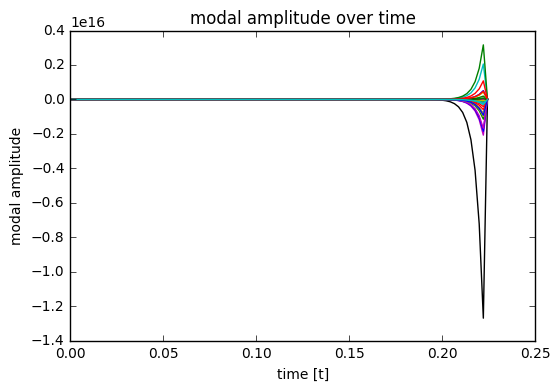

In [17]:
plt.figure()
plt.title("modal amplitude over time")
plt.plot(t_vec, u_vec)
plt.ylabel("modal amplitude")
plt.xlabel("time [t]")
plt.show()

What can be seen from the modal amplitude is that the solution seems harmonic when a constant force is applied. This corresponds to the particular solution of a step force applied at time $t=0$, which is what happens here. This leads to the solution:

$$
u_{part}(t) = \frac{F}{k}\left[1 - \cos{\omega_n t}\right]
$$

This seems to work for the first modal frequency, but for higher frequencies errors occur. 

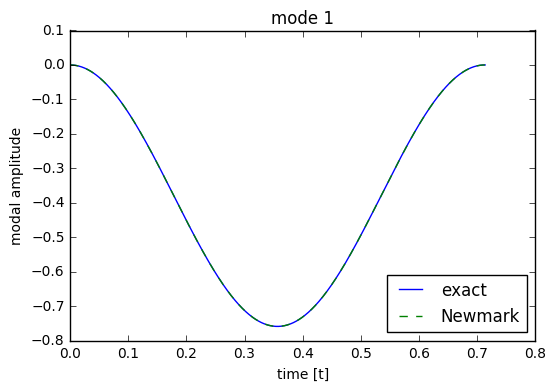

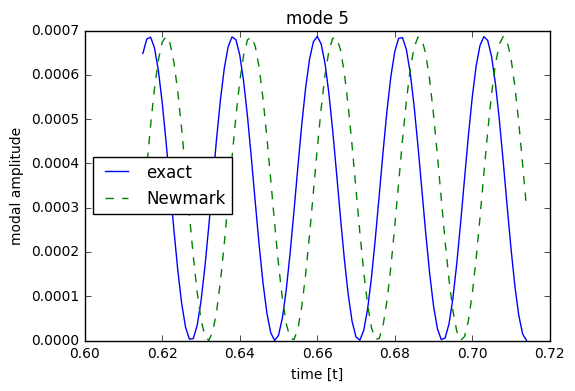

In [16]:
freqs = np.array(eigvalues)**0.5
Modal_amps = np.array([F_modal / K_modal.diagonal()]) * (1 - np.cos(freqs * t_vec[:, np.newaxis]))

mode = 0
plt.figure()
plt.title("mode {}".format(str(mode+1)))
plt.plot(t_vec, Modal_amps[:, mode].real, label="exact")
plt.plot(t_vec, u_vec[:, mode], '--', label="Newmark")
plt.legend(loc='best')
plt.ylabel("modal amplitude")
plt.xlabel("time [t]")
plt.show()

mode = 4
plt.figure()
plt.title("mode {}".format(str(mode+1)))
plt.plot(t_vec[-100:], Modal_amps[-100:, mode].real, label="exact")
plt.plot(t_vec[-100:], u_vec[-100:, mode], '--', label="Newmark")
plt.legend(loc='best')
plt.ylabel("modal amplitude")
plt.xlabel("time [t]")
plt.show()

### Extra matrix analysis ###
In the following lines of code we will show some effects that occur when analyzing the modal matrices a bit more. 

Something that is quite surprising to me is that the modal mass matrix is not the identity matrix and the modal stiffness matrix does not contain the eigenvalues on its diagonal. This is surprising to me since the mode shapes (eigenvectors) are normalized. I don't know why the situation is like this but in the end it does not pose any problems.

In [17]:
# For some reason the K_modal matrix does not contain the eigenvalues on the diagonal
# The relative difference between the eigenvalues and the matrix diagonals is still small though
print(np.linalg.norm(K_modal.diagonal() / M_modal.diagonal() - eigvalues) / np.linalg.norm(eigvalues))

1.13871813711e-10


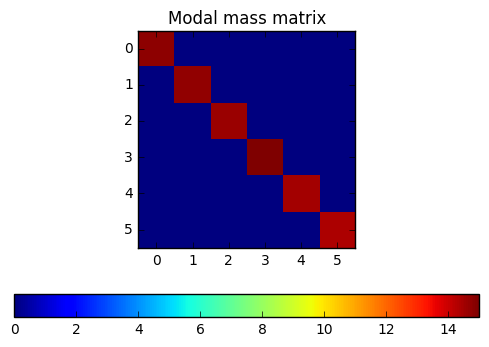

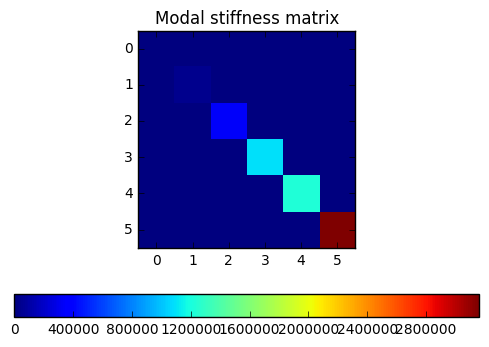

In [18]:
plt.figure()
plt.title("Modal mass matrix")
ax = plt.imshow(M_modal, interpolation='nearest')
cbar = plt.colorbar(ax, orientation='horizontal')
plt.show()

plt.figure()
plt.title("Modal stiffness matrix")
ax = plt.imshow(K_modal, interpolation='nearest')
cbar = plt.colorbar(ax, orientation='horizontal')
plt.show()

In [19]:
# Look at natural frequencies and natural periods
freqs = (np.array(eigvalues)**0.5).real
# the first two eigenvalues seem to be due to boundary conditions

# The modal frequencies are related to natural periods by T = 2*pi/f
periods = 2*np.pi / freqs
print(periods)

[ 0.71337826  0.11485604  0.04159303  0.02321606  0.02163674  0.01340928]
